<a href="https://colab.research.google.com/github/brenoskuk/ML_exercises/blob/master/binary_classification_QP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exam 

### Author: Breno BALDAS SKUK

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exercise 6 - Binary classification of points

### 1 - Data generation

In [ ]:
def gaussian_data_generation(n, mean, cov):
  # create data which follows a multivariate Gaussian distribution
  X = np.random.multivariate_normal(mean, cov, n) 
  return X

def generate_data_cov(n, mean_0, mean_1, cov = 0.15):
  # n is the number of points of each class   
  cov_I = np.array([[cov, 0], [0, cov]])
  
  X_0=gaussian_data_generation(n, mean_0, cov_I)
  y_0=-np.ones(n)

  X_1=gaussian_data_generation(n, mean_1, cov_I)
  y_1=np.ones(n)

  X=np.concatenate((X_0,X_1))
  y=np.concatenate((y_0,y_1))
        


  return X, y

In [ ]:
def plot_data(X,y):
  fig1 = plt.figure(figsize=(6, 6))
  ax = plt.gca()
  min_tot = np.min(X)
  max_tot = np.max(X)
  symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
  k = np.unique(y).shape[0]
  color_blind_list = sns.color_palette("colorblind", k)
  for i, label in enumerate(y):
      if y[i] == -1:
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[(0)]],
                    s=80, marker=symlist[int(label)])
      else:
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[(1)]],
                    s=80, marker=symlist[int(label)])
      
      

def plot_result(X,y,W = [0,0], xylim = 2):
  fig = plt.figure(figsize=(6, 6))
  xx = np.linspace(-5,5,100)
  yy = -(W[0]*xx)/(W[1])
  plt.plot(xx, yy, '-r')
  ax = plt.gca()
  min_tot = np.min(X)
  max_tot = np.max(X)
  symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
  k = np.unique(y).shape[0]
  color_blind_list = sns.color_palette("colorblind", k)
  for i, label in enumerate(y):
      if y[i] == -1:
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[(0)]],
                    s=80, marker=symlist[int(label)])
      else:
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[(1)]],
                    s=80, marker=symlist[int(label)])
  plt.ylim(-xylim, xylim)
  plt.xlim(-xylim, xylim)
  plt.show()

### 2 - Implementing newton method for centering problem over a Quadratic Programming

### 2.1 Newton method

In [ ]:
def orig_f(Q,p,v):
  result = float((v.T.dot(Q)).dot(v) + p.T.dot(v))
  return result

In [ ]:
# f = tf0 + phi
def f(Q,p,b,t,v):
  n = v.shape[0]
  # compute sum of logs simultaneously
  sum_log = 0
  for i in range(n):
    value = float(v[i])
    # first constraint
    sum_log += np.log(-value + b[i])
    # second constraint
    sum_log += np.log(value)

  result = float(t*(v.T @ Q @v  + p.T @ v) - sum_log)
  
  return result

In [ ]:
def grad_f(Q,p,b,t,v):
  n = v.shape[0]
  # compute gradient of phi
  grad_phi = np.zeros((p.shape))
  for i in range(n):
    value = float(v[i])
    grad_phi[i] = 1/(-value + b[i])
    grad_phi[i] += 1/(-value)
  
  # sum with gradient of t*f0
  result = t*((Q.T + Q) @ v) + t*p + grad_phi
  return result

In [ ]:
def hessian_f(Q,p,b,t,v):
  n = v.shape[0]
  # compute hessian of phi
  hess_phi = np.eye(n)
  for i in range(n):
    value = float(v[i])
    hess_phi[i][i] = 1/((value - b[i])**2)
    hess_phi[i][i] += 1/((value)**2)
  return t*(Q.T + Q) + hess_phi

In [ ]:
def backtracking(Q,p,b,t,x, delta_x, f0, f1 ,alpha, beta):
  theta = 0.01
  f0_delta = f(Q,p,b,t,x + theta*delta_x)
  while(f0_delta > f0 + alpha*theta*(f1.T @ delta_x)):
    theta = beta*theta
    f0_delta = f(Q,p,b,t,x + theta*delta_x)
  return theta

In [ ]:
def newton(Q,p,b,t,x0,eps):
  x = x0
  stop = False
  # alpha in [0,0.5] and beta in [0,1]
  alpha = 0.2
  beta = 0.5
  n_it = 0
  while stop == False:
    n_it += 1

    
    f0 = f(Q,p,b,t,x)
    # compute current gradients to use in newton step
    
    f1 = grad_f(Q,p,b,t,x)
    f2 = hessian_f(Q,p,b,t,x)

    # compute inverse
    f2i = np.linalg.inv(f2)
    
    delta_x = -f2i @ f1
    
    # stopping criterion

    lambda_2 = float(f1.T @ f2i @ f1)
    
    #print('lambda^2 = ',lambda_2)
    if (lambda_2/2 <= eps):
      stop = True
    

    # compute step size (there seems to be a problem with backtracking)
    theta = backtracking(Q, p, b, t, x, delta_x, f0, f1 , alpha, beta)
    #theta = 0.01
    #print('delta_x = ', delta_x)
    x = x + theta*delta_x
    #print (x)
  return x, n_it

### 2.2 Barrier Method

In [ ]:
def barr_method(Q,p,b,x0,eps,mu = 10):
  # choose t
  t = 1

  m = x0.shape[0]
  x, n_it = newton(Q,p,b,t,x0,eps)
  iterates = [x0,x]
  n_iterations = [0,n_it]
  while (m/t >= eps):
    t = mu*t
    x, n_it = newton(Q,p,b,t,x,eps) 
    iterates.append(x)
    n_iterations.append(n_it + np.sum(n_iterations))
    
  return iterates, n_iterations

## 3 - Solving data separation program (DS) with the barrier method

OBS: There is an error where sometimes a negative log is calculated. I've spent A LOT of time trying to find it but well, time is up. The method works otherwise! 

### 3.1 Generating random binary problems over $R^2$

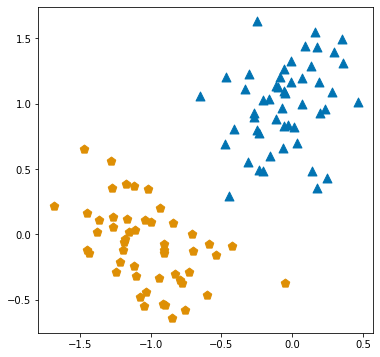

In [ ]:
# regularization parameter
C = 10

# number of points (must be pair for simplicity's sake)
n = 100

cov = 0.1
mean_0 = [0, 1]        
mean_1 = [-1, 0]

X,y = generate_data_cov(int(n/2),mean_0, mean_1, cov)

plot_data(X,y)

We have shown that the dual of (DS) is equivalent to a (QP) with

$ Q = \frac{1}{2} diag(y)XX^Tdiag(y) $ 

$ p = -1_n $

$ b = C1_n$

We can thus reuse the code of the HW2 with some adjustments, since there is another set of constraits we now have 
$$-\phi(x) = \sum^{m/2}_{i=1}{log(-x_i + b_i)} + \sum^{m}_{i=m/2+1}{log(x_i)}$$ 
It suffices to change the functions that calculate it

In [ ]:
# corresponding values
Y = np.diag(y)
Q = 0.5 * (Y.T) @ X @ (X.T) @ Y
p = -1*np.ones((n, 1))
b = C*np.ones((n,1))

In [ ]:
# initial value
v0 = C*0.5*np.ones((n,1))
#v0 = np.zeros((n,1))

Solving dual using barrier method

In [ ]:
# fixed hyperparameters
lamb = 10
mu = 50
eps = 0.1

In [ ]:
ite, _ = barr_method(Q,p,b,v0,eps,mu)
print('finished')

finished


## 3.3 Obtaining solution of the Primal 

In [ ]:
vp = np.array(ite[-1])

In [ ]:
eps_zero = 0.01
for i in range(vp.shape[0]):
  # set thresh to zero
  if vp[i] < eps_zero:
    vp[i] = 0
print(vp.T)

[[0.         9.99959909 0.         0.         0.         0.01378296
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         7.51648474 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         6.48132736 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.      

Since $$(C - \alpha_i)z_i = 0$$ 
Non null values mean that $z_i = 0$.
Values equal to Z mean that $z_i > 0$
We can use this to obtain $w$:
$$w = \sum^{m}_{i=1}\alpha_iy_ix_i$$


In [ ]:
w = (Y @ X).T @ vp

In [ ]:
w

array([[-2.08313329],
       [-3.03162031]])

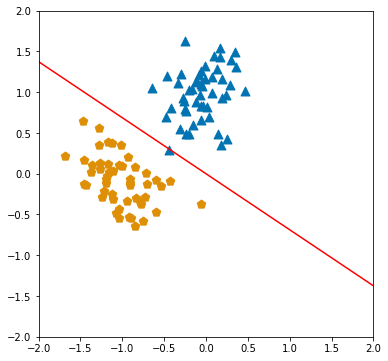

In [ ]:
plot_result(X,y,W = [w[0],w[1]], xylim = 2)

## Hyperparameter C analisys

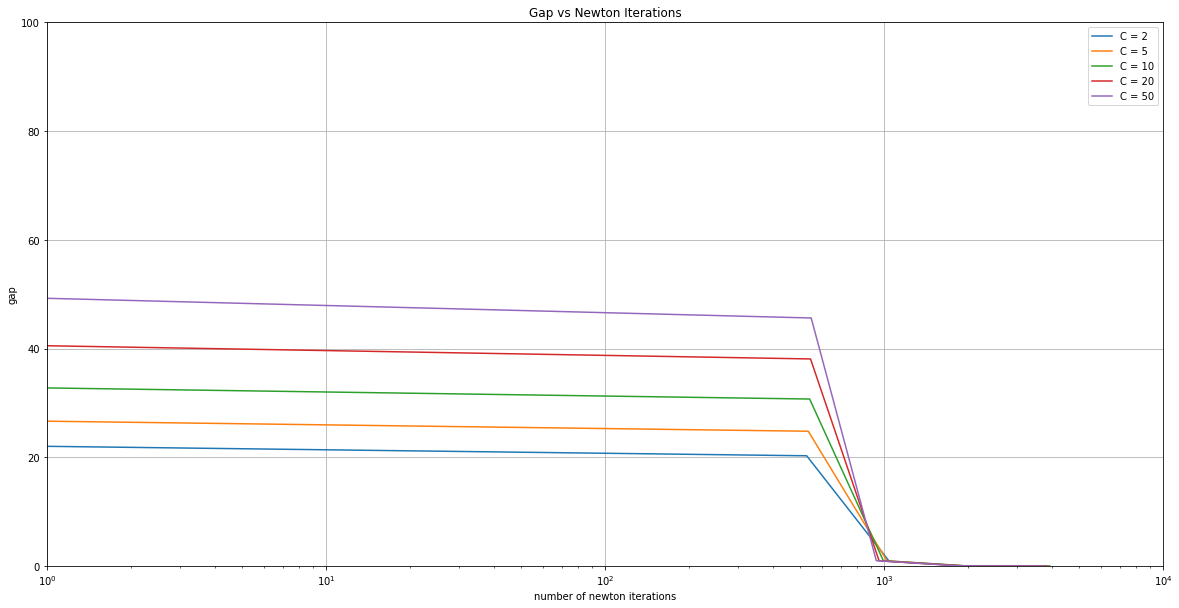

In [ ]:
# number of samples
n = 50
# fixed lambda
lamb = 10
# chose according to what was seen in HW3
mu = 50

fig, ax = plt.subplots(figsize=(20, 10))

# random generation
cov = 0.5
mean_0 = [0, 1]        
mean_1 = [-1, 0]

X,y = generate_data_cov(int(n/2),mean_0, mean_1, cov)

# equivalence between (DS) and (QP)
Y = np.diag(y)
Q = 0.5 * (Y.T) @ X @ (X.T) @ Y
p = -1*np.ones((n, 1))

# initial value must be feasible
v0 = 2*0.5*np.ones((n,1))

eps = 0.01
op_values = []
C_values = [2,5,10,20,50]
for C in C_values:
  
  b = C*np.ones((n,1))

  ite, n_ite = barr_method(Q,p,b,v0,eps,mu)

  distances = []
  vp = ite[-1]
  fp = f0(Q,p,vp)
  op_values.append(vp)
  for i in range(len(ite)):
    d = f0(Q,p,ite[i]) - fp
    distances.append(d)

  # Data for plotting

  label = 'C = ' + str(C)

  ax.semilogx(n_ite, distances, label=label)
plt.xlim(1, 10000)
plt.ylim(0, 100)
ax.set(xlabel='number of newton iterations', ylabel='gap',
        title='Gap vs Newton Iterations')
ax.grid()
ax.legend();
plt.show()


### Comment: It seems that the greater C is, the more "accurate" is the final solution, as we can see the curve with greater mu attain a lower gap for 1000 iterations. 

We can see that for greater values of mu greater, the solution is obtained with a reasonable number of iterations. 
Also, as the obtained solution is the same, the choice of $\mu$ won't impact $w$.
